In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

import warnings
warnings.filterwarnings("ignore")

# Load data
df = pd.read_csv("fintech_competition_40k.csv")

# Create binary target
df['loan_status'] = df['loan_status'].apply(
    lambda x: 0 if x in ['Fully Paid', 'Current'] else 1
)

# Basic cleaning
if 'term' in df.columns:
    df['term'] = df['term'].str.extract('(\d+)').astype(float)

if 'emp_length' in df.columns:
    df['emp_length'] = df['emp_length'].str.extract('(\d+)')
    df['emp_length'] = df['emp_length'].fillna(0).astype(float)

# DROP HIGH CARDINALITY COLUMNS (IMPORTANT)
cols_to_drop = ['id','member_id','url','title','emp_title','zip_code','desc']
for col in cols_to_drop:
    if col in df.columns:
        df = df.drop(columns=col)

print("Remaining columns:", df.shape)


Remaining columns: (12084, 28)


In [3]:
# Separate features and target
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (9667, 27)
Test shape: (2417, 27)


In [4]:
# Identify column types
num_cols = X_train.select_dtypes(include=['int64','float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

print("Numeric columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))


Numeric columns: ['loan_amnt', 'int_rate', 'monthly_payment', 'emp_length', 'annual_inc', 'total_dti', 'delinq_2yrs', 'open_acc', 'cur_acct_delinq', 'tot_coll_amt', 'tot_cur_bal', 'mort_acc', 'num_accts_120_pd', 'pub_rec_bankruptcies', 'tax_liens', 'credit_limit', 'total_bal_ex_mort']
Categorical columns: ['loan_term', 'sub_grade', 'home_ownership', 'verification_status', 'loan_purpose', 'addr_state', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


In [5]:
from sklearn.impute import SimpleImputer

# Create imputers
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

# Fit only on TRAIN
X_train[num_cols] = imputer_num.fit_transform(X_train[num_cols])
X_test[num_cols] = imputer_num.transform(X_test[num_cols])

X_train[cat_cols] = imputer_cat.fit_transform(X_train[cat_cols])
X_test[cat_cols] = imputer_cat.transform(X_test[cat_cols])

print("Imputation completed successfully.")


Imputation completed successfully.


In [6]:
# One-hot encoding
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

print("After encoding:")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


After encoding:
Train shape: (9667, 122)
Test shape: (2417, 122)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Train model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Predict probabilities
log_probs = log_model.predict_proba(X_test)[:, 1]

# ROC-AUC
log_auc = roc_auc_score(y_test, log_probs)
print("Logistic Regression ROC-AUC:", log_auc)

# Classification Report (0.5 threshold)
log_preds = (log_probs > 0.5).astype(int)
print("\nClassification Report (Threshold=0.5):")
print(classification_report(y_test, log_preds))


Logistic Regression ROC-AUC: 0.5669238835170094

Classification Report (Threshold=0.5):
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2153
           1       0.00      0.00      0.00       264

    accuracy                           0.89      2417
   macro avg       0.45      0.50      0.47      2417
weighted avg       0.79      0.89      0.84      2417



In [8]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"   # important for imbalance
)

rf.fit(X_train, y_train)

# Predict probabilities
rf_probs = rf.predict_proba(X_test)[:, 1]

# ROC-AUC
rf_auc = roc_auc_score(y_test, rf_probs)
print("Random Forest ROC-AUC:", rf_auc)

# Classification Report
rf_preds = (rf_probs > 0.5).astype(int)
print("\nClassification Report (Threshold=0.5):")
print(classification_report(y_test, rf_preds))


Random Forest ROC-AUC: 0.7499604146434151

Classification Report (Threshold=0.5):
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2153
           1       1.00      0.16      0.28       264

    accuracy                           0.91      2417
   macro avg       0.95      0.58      0.62      2417
weighted avg       0.92      0.91      0.88      2417



In [9]:
thresholds = [0.3, 0.4, 0.5, 0.6]

for t in thresholds:
    print("\n============================")
    print(f"Threshold: {t}")

    preds = (rf_probs > t).astype(int)
    print(classification_report(y_test, preds))



Threshold: 0.3
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2153
           1       0.76      0.19      0.31       264

    accuracy                           0.91      2417
   macro avg       0.84      0.59      0.63      2417
weighted avg       0.89      0.91      0.88      2417


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2153
           1       0.98      0.17      0.29       264

    accuracy                           0.91      2417
   macro avg       0.94      0.58      0.62      2417
weighted avg       0.92      0.91      0.88      2417


Threshold: 0.5
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2153
           1       1.00      0.16      0.28       264

    accuracy                           0.91      2417
   macro avg       0.95      0.58      0.62      2417
weighted avg       0.92   

In [10]:
# Create dataframe for evaluation
results = X_test.copy()
results["actual_default"] = y_test.values
results["predicted_pd"] = rf_probs

# Create risk tiers
results["risk_tier"] = pd.cut(
    results["predicted_pd"],
    bins=[0, 0.2, 0.4, 1],
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

results.head()


,loan_amnt,int_rate,monthly_payment,emp_length,annual_inc,total_dti,delinq_2yrs,open_acc,cur_acct_delinq,tot_coll_amt,...,addr_state_WI,addr_state_WV,addr_state_WY,application_type_Joint App,hardship_flag_Y,disbursement_method_DirectPay,debt_settlement_flag_Y,actual_default,predicted_pd,risk_tier
6620,7950.0,15.31,276.80,3.0,74000.0,17.90,1.0,6.0,0.0,0.0,...,False,False,False,False,0,False,False,1,0.090,Low Risk
11113,14700.0,11.47,484.54,0.0,20000.0,47.90,1.0,6.0,0.0,0.0,...,False,False,False,True,0,False,False,0,0.100,Low Risk
8408,20000.0,16.14,704.53,10.0,46000.0,22.32,1.0,25.0,0.0,0.0,...,False,False,False,False,0,True,False,0,0.125,Low Risk
3060,5200.0,18.25,188.65,1.0,25000.0,9.31,0.0,1.0,0.0,0.0,...,False,False,False,False,0,False,False,1,0.145,Low Risk
2034,25000.0,10.99,543.44,10.0,72000.0,18.06,0.0,16.0,0.0,0.0,...,False,False,False,False,0,False,False,0,0.095,Low Risk


In [11]:
tier_summary = results.groupby("risk_tier")["actual_default"].agg(
    ["count", "mean"]
).rename(columns={"mean": "default_rate"})

tier_summary


,count,default_rate
risk_tier,,
Low Risk,2168,0.080720
Medium Risk,187,0.235294
High Risk,46,0.978261


In [12]:
threshold = 0.3

results["approve"] = (results["predicted_pd"] < threshold).astype(int)

approval_rate = results["approve"].mean()
default_rate_approved = results[results["approve"] == 1]["actual_default"].mean()

print("Approval Rate:", round(approval_rate, 3))
print("Default Rate Among Approved:", round(default_rate_approved, 3))


Approval Rate: 0.97
Default Rate Among Approved: 0.09


In [13]:
# Assume exposure = loan amount (if exists)
if "loan_amnt" in results.columns:
    results["exposure"] = results["loan_amnt"]
else:
    results["exposure"] = 10000  # fallback assumption

LGD = 0.6  # assume 60% loss given default

results["expected_loss"] = results["predicted_pd"] * results["exposure"] * LGD

results[["predicted_pd", "exposure", "expected_loss"]].head()


,predicted_pd,exposure,expected_loss
6620,0.090,7950.0,429.3
11113,0.100,14700.0,882.0
8408,0.125,20000.0,1500.0
3060,0.145,5200.0,452.4
2034,0.095,25000.0,1425.0


In [14]:
total_expected_loss = results["expected_loss"].sum()

print("Total Expected Loss (Test Portfolio):", round(total_expected_loss, 2))


Total Expected Loss (Test Portfolio): 2533663.42


In [15]:
def suggested_rate(pd):
    if pd < 0.2:
        return "Standard Rate"
    elif pd < 0.4:
        return "Standard + 2%"
    else:
        return "High Risk Premium / Decline"

results["pricing_suggestion"] = results["predicted_pd"].apply(suggested_rate)

results[["predicted_pd", "risk_tier", "pricing_suggestion"]].head()


,predicted_pd,risk_tier,pricing_suggestion
6620,0.090,Low Risk,Standard Rate
11113,0.100,Low Risk,Standard Rate
8408,0.125,Low Risk,Standard Rate
3060,0.145,Low Risk,Standard Rate
2034,0.095,Low Risk,Standard Rate


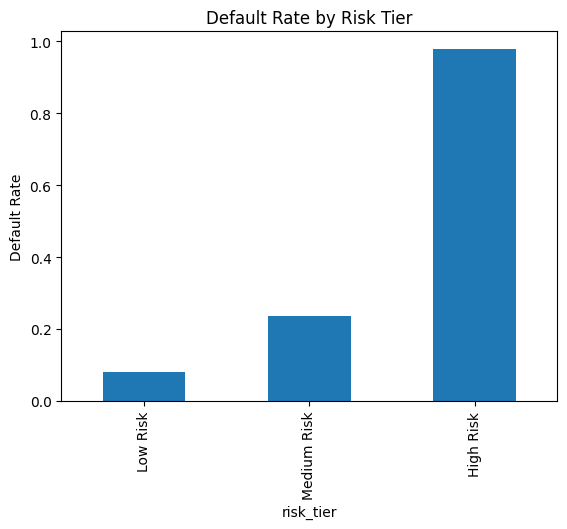

In [16]:
plt.figure()
results.groupby("risk_tier")["actual_default"].mean().plot(kind="bar")
plt.title("Default Rate by Risk Tier")
plt.ylabel("Default Rate")
plt.show()


In [17]:
def evaluate_applicant(applicant_dict):

    # Create empty row with all training columns
    new_app = pd.DataFrame(columns=X.columns)
    new_app.loc[0] = np.nan

    # Fill with applicant values
    for key, value in applicant_dict.items():
        if key in new_app.columns:
            new_app.at[0, key] = value

    # Impute
    new_app[num_cols] = imputer_num.transform(new_app[num_cols])
    new_app[cat_cols] = imputer_cat.transform(new_app[cat_cols])

    # One-hot encode
    new_app = pd.get_dummies(new_app, drop_first=True)

    # Align with training features
    new_app = new_app.reindex(columns=X_train.columns, fill_value=0)

    # Predict probability
    pd_score = rf.predict_proba(new_app)[0][1]

    # Risk Tier + Decision
    if pd_score < 0.2:
        tier = "Low Risk"
        decision = "APPROVE"
        pricing = "Standard Interest Rate"
    elif pd_score < 0.4:
        tier = "Medium Risk"
        decision = "CONDITIONAL APPROVAL"
        pricing = "Standard + 2% Risk Premium"
    else:
        tier = "High Risk"
        decision = "REJECT or MANUAL REVIEW"
        pricing = "High Risk Premium"

    # Expected Loss
    exposure = applicant_dict.get("loan_amnt", 10000)
    LGD = 0.6
    expected_loss = pd_score * exposure * LGD

    print("----- CREDIT EVALUATION RESULT -----")
    print("Predicted Probability of Default:", round(pd_score, 3))
    print("Risk Tier:", tier)
    print("Decision:", decision)
    print("Suggested Pricing:", pricing)
    print("Estimated Expected Loss:", round(expected_loss, 2))


In [18]:
sample_applicant = {
    "loan_amnt": 15000,
    "term": 36,
    "int_rate": 12.5,
    "annual_inc": 60000,
    "dti": 18,
    "emp_length": 5,
    "home_ownership": "RENT",
    "purpose": "debt_consolidation"
}

evaluate_applicant(sample_applicant)


----- CREDIT EVALUATION RESULT -----
Predicted Probability of Default: 0.185
Risk Tier: Low Risk
Decision: APPROVE
Suggested Pricing: Standard Interest Rate
Estimated Expected Loss: 1665.0
